# Expectile Regression

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/StatMixedML/LightGBMLSS/blob/master/docs/examples/Expectile_Regression.ipynb)

# Imports

In [2]:
from lightgbmlss.model import *
from lightgbmlss.distributions.Expectile import *
from lightgbmlss.datasets.data_loader import load_simulated_gaussian_data

import plotnine
from plotnine import *
plotnine.options.figure_size = (20, 10)

# Data

In [3]:
# The data is a simulated Gaussian as follows, where x is the only true feature and all others are noise variables
    # loc = 10
    # scale = 1 + 4*((0.3 < x) & (x < 0.5)) + 2*(x > 0.7)

train, test = load_simulated_gaussian_data()

X_train, y_train = train.filter(regex="x"), train["y"].values
X_test, y_test = test.filter(regex="x"), test["y"].values

dtrain = lgb.Dataset(X_train, label=y_train)

# Expectile Specification

In [4]:
lgblss = LightGBMLSS(
    Expectile(stabilization="None",              # Options are "None", "MAD", "L2".
              expectiles = [0.05, 0.95],         # List of expectiles to be estimated, in increasing order.
              penalize_crossing = True           # Whether to include a penalty term to discourage crossing of expectiles.
              )    
)

# Hyper-Parameter Optimization

Any LightGBM hyperparameter can be tuned, where the structure of the parameter dictionary needs to be as follows:

    - Float/Int sample_type
        - {"param_name": ["sample_type", low, high, log]}
            - sample_type: str, Type of sampling, e.g., "float" or "int"
            - low: int, Lower endpoint of the range of suggested values
            - high: int, Upper endpoint of the range of suggested values
            - log: bool, Flag to sample the value from the log domain or not
        - Example: {"eta": "float", low=1e-5, high=1, log=True]}

    - Categorical sample_type
        - {"param_name": ["sample_type", ["choice1", "choice2", "choice3", "..."]]}
            - sample_type: str, Type of sampling, either "categorical"
            - choice1, choice2, choice3, ...: str, Possible choices for the parameter
        - Example: {"boosting": ["categorical", ["gbdt", "dart"]]}

    - For parameters without tunable choice (this is needed if tree_method = "gpu_hist" and gpu_id needs to be specified)
        - {"param_name": ["none", [value]]},
            - param_name: str, Name of the parameter
            - value: int, Value of the parameter
        - Example: {"gpu_id": ["none", [0]]}

In [5]:
param_dict = {
    "eta":                      ["float", {"low": 1e-5,   "high": 1,     "log": True}],
    "max_depth":                ["int",   {"low": 1,      "high": 10,    "log": False}],
    "num_leaves":               ["int",   {"low": 255,    "high": 255,   "log": False}],  # set to constant for this example
    "min_data_in_leaf":         ["int",   {"low": 20,     "high": 20,    "log": False}],  # set to constant for this example
    "min_gain_to_split":        ["float", {"low": 1e-8,   "high": 40,    "log": False}],
    "min_sum_hessian_in_leaf":  ["float", {"low": 1e-8,   "high": 500,   "log": True}],
    "subsample":                ["float", {"low": 0.2,    "high": 1.0,   "log": False}],
    "feature_fraction":         ["float", {"low": 0.2,    "high": 1.0,   "log": False}],
    "boosting":                 ["categorical", ["gbdt"]],
}

np.random.seed(123)
opt_param = lgblss.hyper_opt(param_dict,
                             dtrain,
                             num_boost_round=100,        # Number of boosting iterations.
                             nfold=5,                    # Number of cv-folds.
                             early_stopping_rounds=20,   # Number of early-stopping rounds
                             max_minutes=10,             # Time budget in minutes, i.e., stop study after the given number of minutes.
                             n_trials=30,                # The number of trials. If this argument is set to None, there is no limitation on the number of trials.
                             silence=False,              # Controls the verbosity of the trail, i.e., user can silence the outputs of the trail.
                             seed=123,                   # Seed used to generate cv-folds.
                             hp_seed=None                # Seed for random number generator used in the Bayesian hyperparameter search.
                             )

[I 2023-08-11 12:21:09,469] A new study created in memory with name: LightGBMLSS Hyper-Parameter Optimization


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-08-11 12:21:12,718] Trial 0 finished with value: 2455.671630859375 and parameters: {'eta': 4.999979903379203e-05, 'max_depth': 6, 'num_leaves': 255, 'min_data_in_leaf': 20, 'min_gain_to_split': 21.93993866573528, 'min_sum_hessian_in_leaf': 0.0003530133520827798, 'subsample': 0.4971819264686692, 'feature_fraction': 0.3707311537482785, 'boosting': 'gbdt'}. Best is trial 0 with value: 2455.671630859375.
[I 2023-08-11 12:21:14,662] Trial 1 finished with value: 1905.1077880859375 and parameters: {'eta': 0.031600943671035775, 'max_depth': 3, 'num_leaves': 255, 'min_data_in_leaf': 20, 'min_gain_to_split': 25.283240746368264, 'min_sum_hessian_in_leaf': 49.082392515255734, 'subsample': 0.6788944834474666, 'feature_fraction': 0.9258044091945574, 'boosting': 'gbdt'}. Best is trial 1 with value: 1905.1077880859375.
[I 2023-08-11 12:21:18,260] Trial 2 finished with value: 2163.520751953125 and parameters: {'eta': 0.005894981780547752, 'max_depth': 9, 'num_leaves': 255, 'min_data_in_leaf': 2

# Model Training

In [6]:
np.random.seed(123)

opt_params = opt_param.copy()
n_rounds = opt_params["opt_rounds"]
del opt_params["opt_rounds"]

# Train Model with optimized hyperparameters
lgblss.train(opt_params,
             dtrain,
             num_boost_round=n_rounds
             )

# Prediction

In [7]:
# Predicted expectiles
pred_expectile = lgblss.predict(X_test, pred_type="expectiles")

In [8]:
pred_expectile.head()

,expectile_0.05,expectile_0.95
0,6.695340,13.277894
1,6.615792,13.277894
2,8.519470,11.511595
3,4.557220,14.967069
4,6.615792,13.367647


# SHAP Interpretability

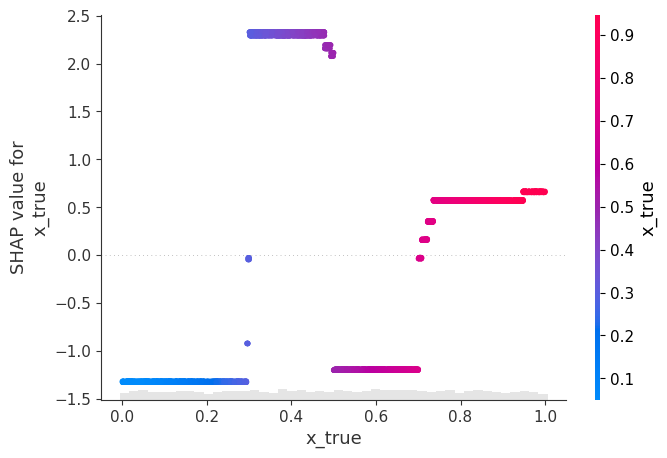

In [9]:
# Partial Dependence Plot of how x acts on selected expectile 
lgblss.expectile_plot(X_test,
                      expectile="expectile_0.95",
                      feature="x_true",
                      plot_type="Partial_Dependence")

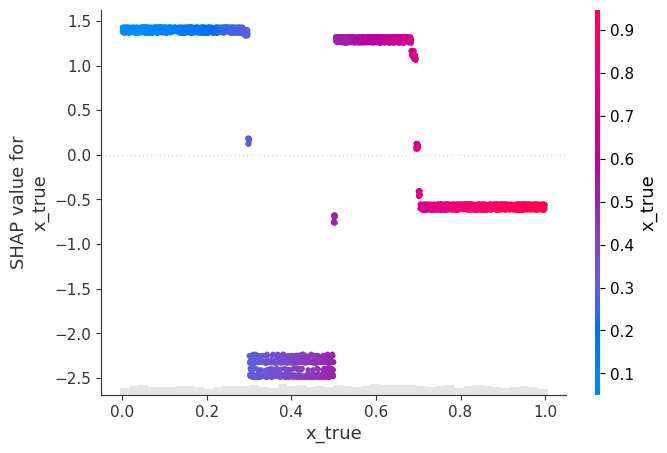

In [10]:
# Partial Dependence Plot of how x acts on selected expectile 
lgblss.expectile_plot(X_test,
                      expectile="expectile_0.05",
                      feature="x_true",
                      plot_type="Partial_Dependence")

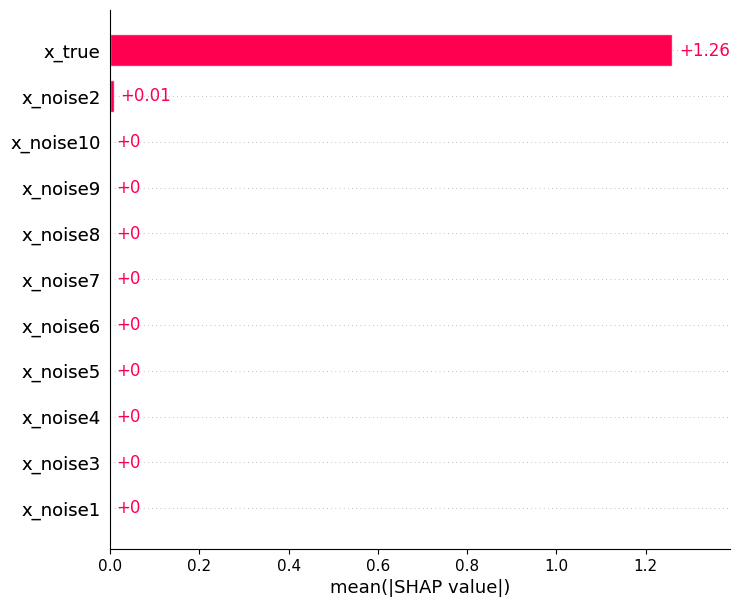

In [11]:
# Global Feature Importance of selected expectile
lgblss.expectile_plot(X_test,
                      expectile="expectile_0.95",
                      plot_type="Feature_Importance")

# Plot of Actual vs. Predicted Expectiles

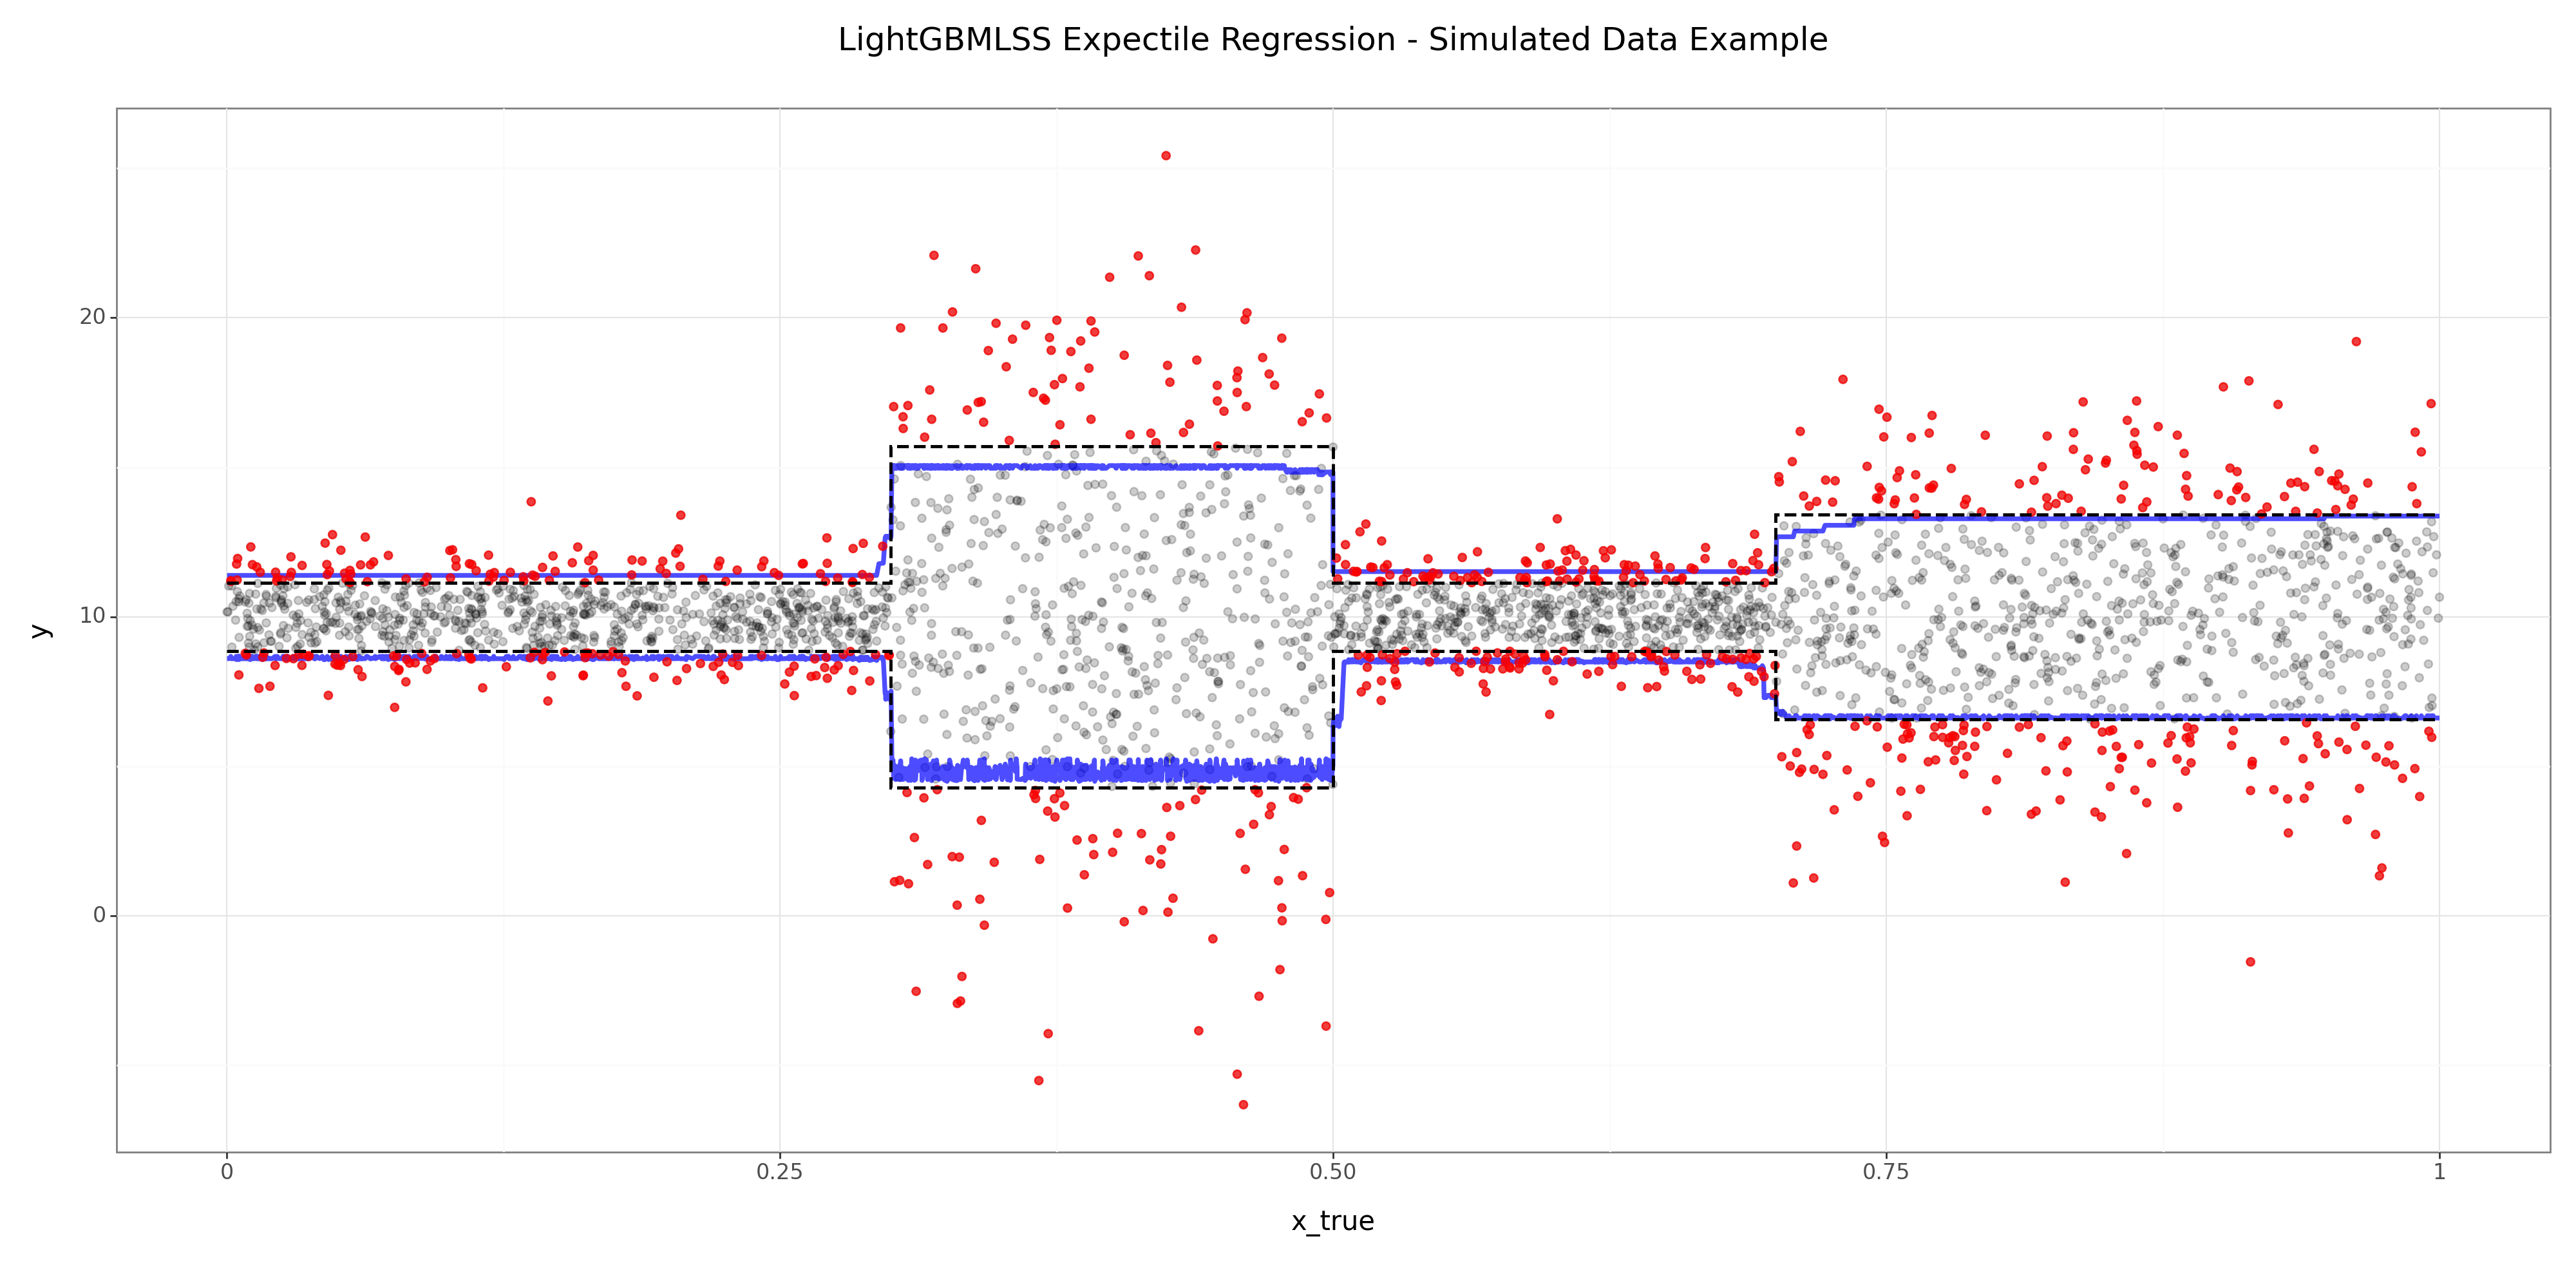

<Figure Size: (2000 x 1000)>

In [12]:
np.random.seed(123)

###
# Actual Expectiles
###
y_loc = np.array([10])
y_scale = np.array([1 + 4*((0.3 < test["x_true"].values) & (test["x_true"].values < 0.5)) + 2*(test["x_true"].values > 0.7)])
tau_lower = np.array([lgblss.dist.tau[0]])
tau_upper = np.array([lgblss.dist.tau[1]])

# Calculates exact expectiles assuming a Normal distribution
expectile_lb = expectile_norm(tau=tau_lower,
                              m=y_loc,
                              sd=y_scale).reshape(-1,)
expectile_ub =  expectile_norm(tau=tau_upper,
                               m=y_loc,
                               sd=y_scale).reshape(-1,)

test["expect"] = np.where(test["y"].values < expectile_lb, 0, np.where(test["y"].values < expectile_ub, 1, 2))
test["alpha"] = np.where(test["y"].values <= expectile_lb, 1, np.where(test["y"].values >= expectile_ub, 1, 0))
df_expectiles = test[test["alpha"] == 1]

# Lower Bound
yl = list(set(expectile_lb))
yl.sort()
yl = [yl[2],yl[0],yl[2],yl[1],yl[1]]
sfunl = pd.DataFrame({"x_true":[0, 0.3, 0.5, 0.7, 1],
                      "y":yl})

# Upper Bound
yu = list(set(expectile_ub))
yu.sort()
yu = [yu[0],yu[2],yu[0],yu[1],yu[1]]
sfunu = pd.DataFrame({"x_true":[0, 0.3, 0.5, 0.7, 1],
                      "y":yu})



###
# Forecasted Expectiles
###
test["lb"] = pred_expectile.iloc[:,0]
test["ub"] = pred_expectile.iloc[:,1]



###
# Plot
###
(ggplot(test,
        aes("x_true",
            "y")) +
 geom_point(alpha = 0.2, color = "black", size = 2) +
 theme_bw(base_size=15) +
 theme(legend_position="bottom",
       plot_title = element_text(hjust = 0.5)) +
 labs(title = "LightGBMLSS Expectile Regression - Simulated Data Example")  +
 geom_line(aes("x_true",
               "ub"),
           size = 1.5,
           color = "blue",
           alpha = 0.7) +
 geom_line(aes("x_true",
               "lb"),
           size = 1.5,
           color = "blue",
           alpha = 0.7) +
 geom_point(df_expectiles,
            aes("x_true",
                "y"),
            color = "red",
            alpha = 0.7,
            size = 2) +
 geom_step(sfunl,
           aes("x_true",
               "y"),
           size = 1,
           linetype = "dashed")  +
 geom_step(sfunu,
           aes("x_true",
               "y"),
           size = 1,
           linetype = "dashed")
)